In [1]:
from sumpy.recurrence import _make_sympy_vec, get_processed_and_shifted_recurrence

from sumpy.expansion.diff_op import (
    laplacian,
    make_identity_diff_op,
)

from sumpy.recurrence import get_recurrence

import sympy as sp
from sympy import hankel1

import numpy as np

import math

import matplotlib.pyplot as plt
from matplotlib import cm, ticker

In [2]:
w = make_identity_diff_op(2)
laplace2d = laplacian(w)
n_init, order, recur_laplace = get_processed_and_shifted_recurrence(laplace2d)

w = make_identity_diff_op(2)
helmholtz2d = laplacian(w) + w
n_init, _, recur_helmholtz = get_processed_and_shifted_recurrence(helmholtz2d)

In [3]:
max_abs = .0000001
var = _make_sympy_vec("x", 2)
rct = sp.symbols("r_{ct}")
s = sp.Function("s")
n = sp.symbols("n")

In [4]:
def compute_derivatives(p):
    var = _make_sympy_vec("x", 2)
    var_t = _make_sympy_vec("t", 2)
    g_x_y = sp.log(sp.sqrt((var[0]-var_t[0])**2 + (var[1]-var_t[1])**2))
    derivs = [sp.diff(g_x_y,
                        var_t[0], i).subs(var_t[0], 0).subs(var_t[1], 0)
                        for i in range(p)]
    return derivs
derivs_laplace = compute_derivatives(8)

In [13]:
def compute_derivatives_h2d(p):
    k = 1
    var = _make_sympy_vec("x", 2)
    var_t = _make_sympy_vec("t", 2)
    abs_dist = sp.sqrt((var[0]-var_t[0])**2 +
                        (var[1]-var_t[1])**2)
    g_x_y = (1j/4) * hankel1(0, k * abs_dist)
    derivs_helmholtz = [sp.diff(g_x_y,
                        var_t[0], i).subs(var_t[0], 0).subs(var_t[1], 0)
                                                for i in range(p)]
    return derivs_helmholtz
derivs_helmholtz = compute_derivatives_h2d(10)

KeyboardInterrupt: 

In [6]:
def evaluate_recurrence_lamb(coord_dict, recur, p, derivs_list):
    subs_dict = {}
    subs_dict[s(-2)] = 0
    subs_dict[s(-1)] = 0
    subs_dict[s(0)] = derivs_list[0].subs(coord_dict)
    subs_dict[s(1)] = derivs_list[1].subs(coord_dict)
    subs_dict[s(2)] = derivs_list[2].subs(coord_dict)
    var = _make_sympy_vec("x", 2)
    for i in range(3, p):
        exp = get_recurrence(recur, i)
        f = sp.lambdify([var[0], var[1], s(i-1), s(i-2), s(i-3), s(i-4), s(i-5)], exp)
        subs_dict[s(i)] = f(coord_dict[var[0]], coord_dict[var[1]], subs_dict[s(i-1)], subs_dict[s(i-2)],
                            subs_dict[s(i-3)], subs_dict[s(i-4)], subs_dict[s(i-5)])
    subs_dict.pop(s(-2))
    subs_dict.pop(s(-1))
    return np.array(list(subs_dict.values()))

In [7]:
def evaluate_true(coord_dict, p, derivs_list):
    retMe = []
    for i in range(p):
        exp = derivs_list[i]
        f = sp.lambdify(var, exp)
        retMe.append(f(coord_dict[var[0]], coord_dict[var[1]]))
    return np.array(retMe)

In [8]:
def compute_error_coord(recur, loc, order, derivs_list):
    var = _make_sympy_vec("x", 2)
    coord_dict = {var[0]: loc[0], var[1]: loc[1]}

    exp = evaluate_recurrence_lamb(coord_dict, recur, order+1, derivs_list)[order].evalf()
    
    true = derivs_list[order].subs(coord_dict).evalf()

    return (np.abs(exp-true)/np.abs(true))

In [9]:
def generate_error_grid(res, order_plot, recur, derivs):
    x_grid = [10**(pw) for pw in np.linspace(-8, 0, res)]
    y_grid = [10**(pw) for pw in np.linspace(-8, 0, res)]
    res=len(x_grid)
    plot_me = np.empty((res, res))
    for i in range(res):
        for j in range(res):
            if abs(x_grid[i]) == abs(y_grid[j]):
                plot_me[i, j] = 1e-16
            else:
                plot_me[i,j] = compute_error_coord(recur, np.array([x_grid[i],y_grid[j]]), order_plot, derivs)
                if plot_me[i,j] == 0:
                    plot_me[i, j] = 1e-16
    return x_grid, y_grid, plot_me

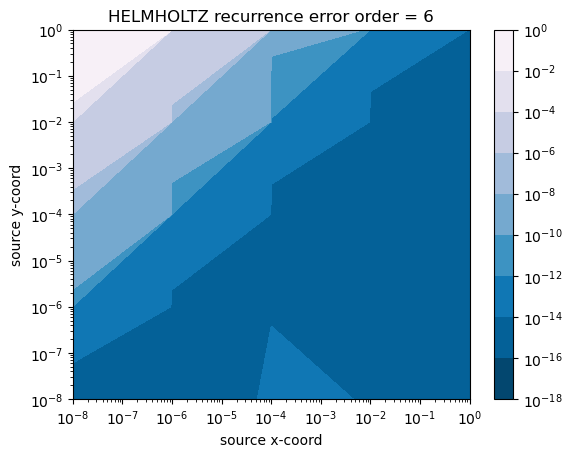

In [10]:
order_plot = 6
x_grid, y_grid, plot_me = generate_error_grid(res=5, order_plot=order_plot, recur=recur_laplace, derivs=derivs_laplace)
                
fig, ax = plt.subplots()
cs = ax.contourf(x_grid, y_grid, plot_me.T, locator=ticker.LogLocator(), cmap=cm.PuBu_r)
cbar = fig.colorbar(cs)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel("source x-coord")
plt.ylabel("source y-coord")
plt.title("HELMHOLTZ recurrence error order = "+str(order_plot))
plt.show()

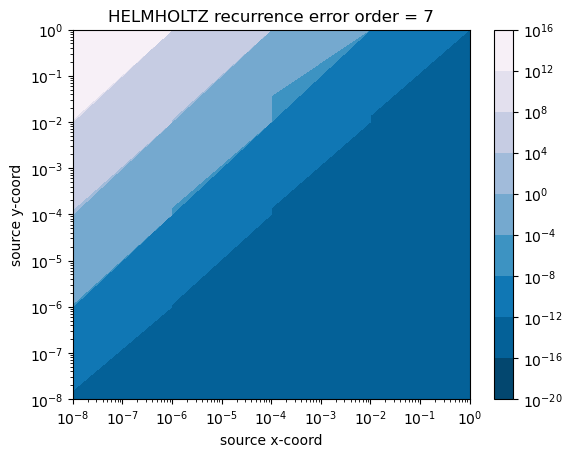

In [12]:
order_plot = 7
x_grid, y_grid, plot_me = generate_error_grid(res=5, order_plot=order_plot, recur=recur_laplace, derivs=derivs_laplace)
                
fig, ax = plt.subplots()
cs = ax.contourf(x_grid, y_grid, plot_me.T, locator=ticker.LogLocator(), cmap=cm.PuBu_r)
cbar = fig.colorbar(cs)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel("source x-coord")
plt.ylabel("source y-coord")
plt.title("HELMHOLTZ recurrence error order = "+str(order_plot))
plt.show()